# Operator Learing - Fourier Neural Operator

Solutions of PDEs are operators that act as mappings between function spaces. They take initial conditions, boundary conditions, and source terms as inputs and yield the PDE solution as output. For instance, in fluid dynamics, the solution operator can compute the flow profile at a specific future time (e.g. $T = 1$) given the initial flow and boundary conditions.


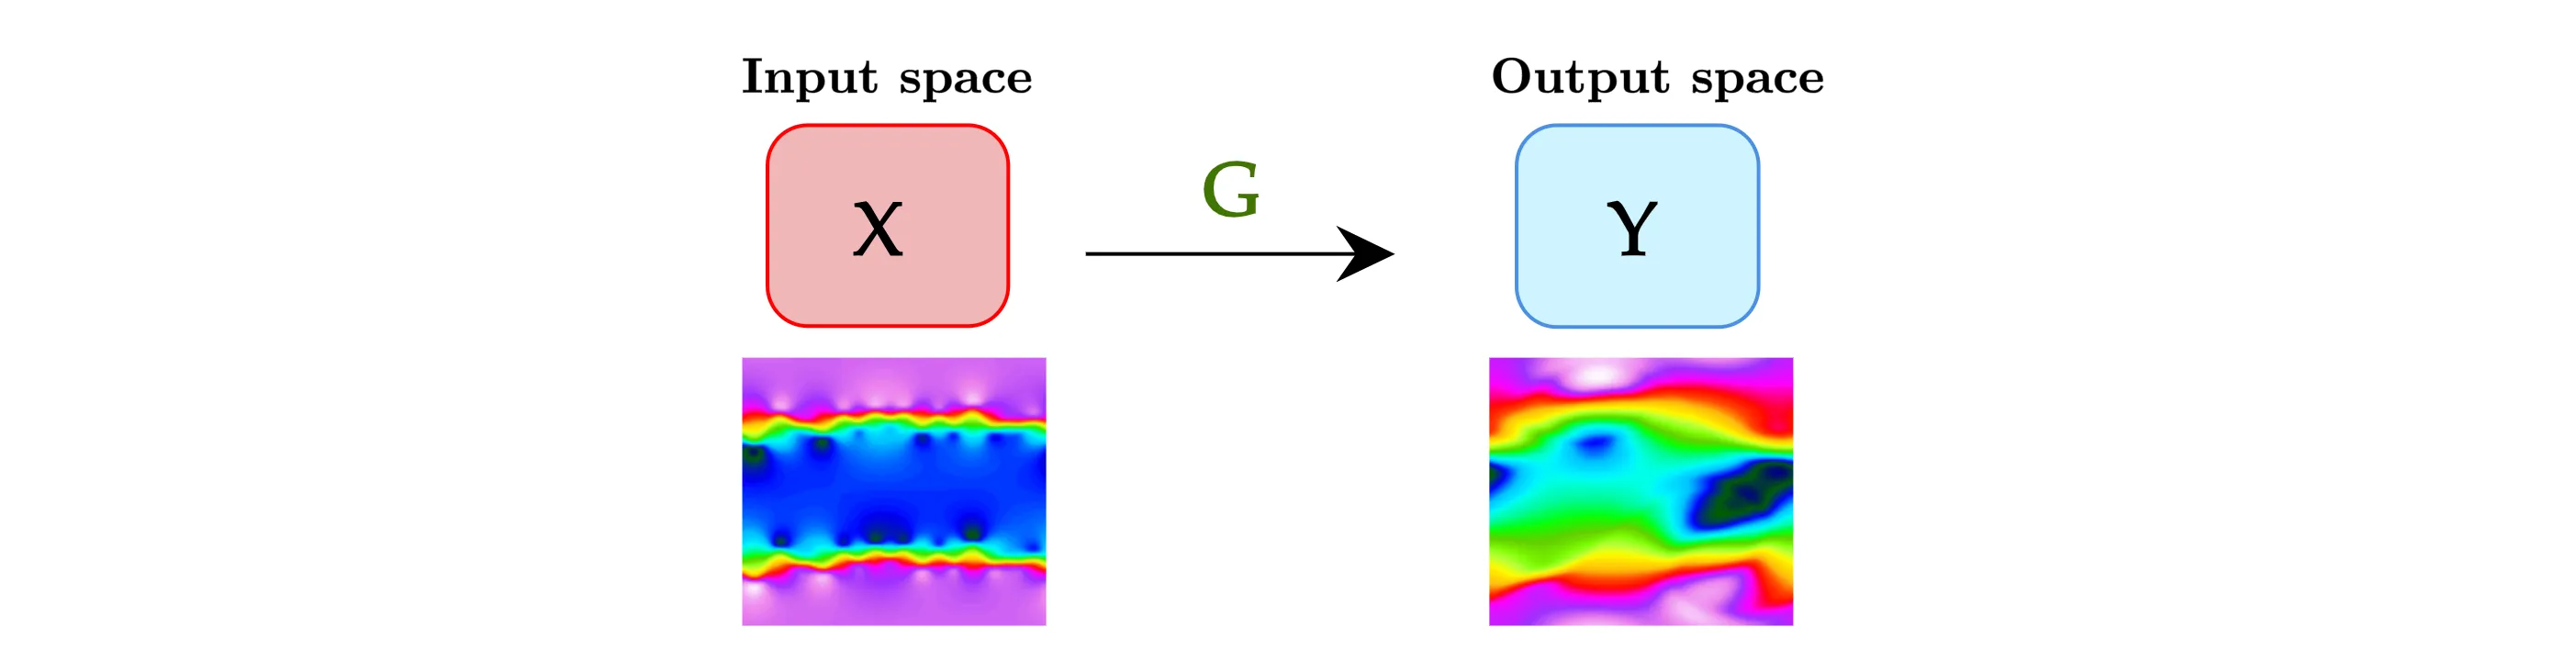

In **operator learning**, models are tasked with handling functions as inputs and outputs, which are stored on a computer in their **discrete representations** (e.g. images). They should have ability to process and generalize across various representations of the inputs, such as different mesh refinements.

Data-driven models that exhibit the mentioned properties are commonly known as ***Neural Operators***.

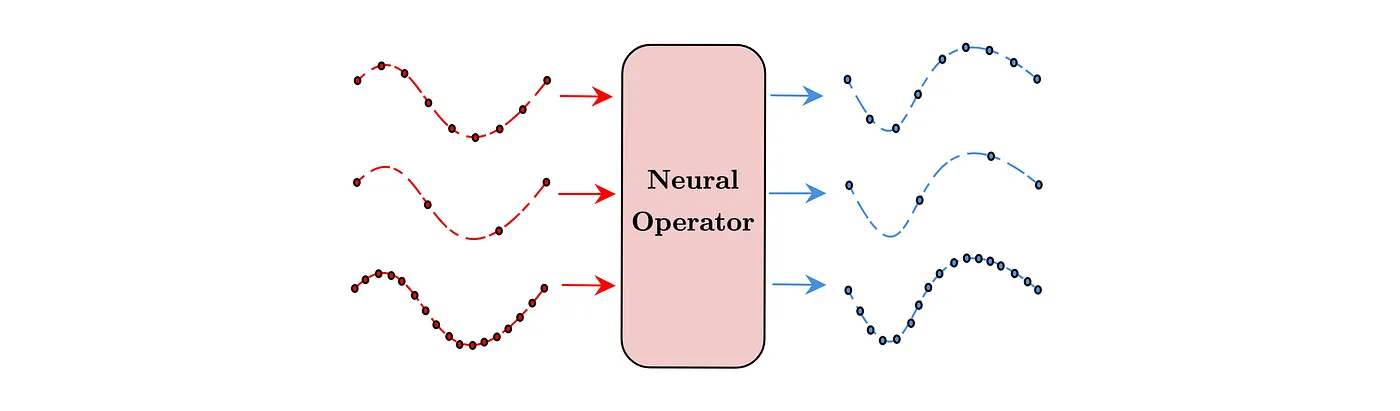



## Fourier Neural Operator (FNO)

- Introduced in the paper [Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/abs/2010.08895).
- FNO is formulated as an **iterative architecture**
- FNO uses **convolutions** parametrized in the **frequency domain** (**global** operations)
- FNO uses **skip connections** to enchance the training

First layer is the **lifting layer** (in the channel dimension, increases the number of channels), while the last layer is the **projection layer** (reduces the number of channels.

You can read the blog at [FNO blog](https://zongyi-li.github.io/blog/2020/fourier-pde/).


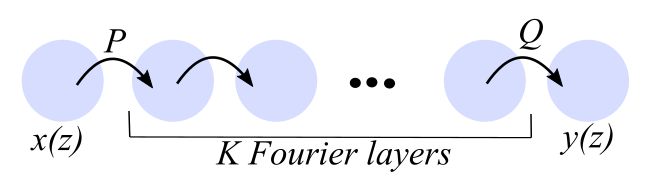

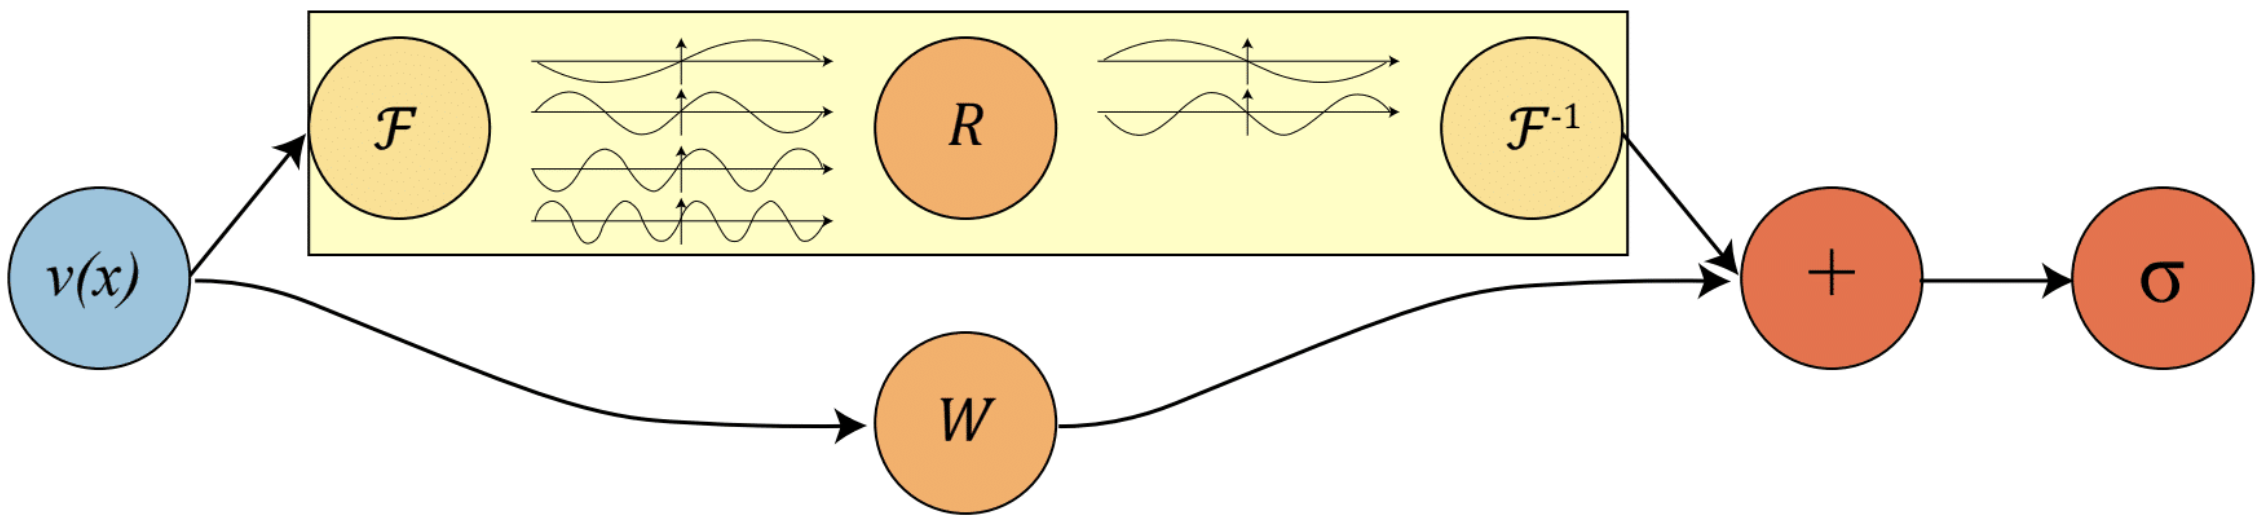

The Fourier layer just consists of three steps:

1. Fourier transform (using FFT)

2. Linear transform on the lower Fourier modes

3. Inverse Fourier transform

In [620]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

In [621]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)

class SpectralConv1d(nn.Module):
    """The *FNO1d* uses *SpectralConv1d* as its crucial part."""
    def __init__(self, in_channels, out_channels, modes1, use_bn=False):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))
        self.use_bn = use_bn
        if self.use_bn:
            self.bn = nn.BatchNorm1d(out_channels)
            
    def compl_mul1d(self, input, weights):
        return torch.einsum("bix,iox->box", input, weights)
    
    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft(x)
        actual_modes = min(self.modes1, x.size(-1)//2 + 1)
        
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1, 
                           device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :actual_modes] = self.compl_mul1d(x_ft[:, :, :actual_modes], 
                                                      self.weights1[:, :, :actual_modes])
        
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        if self.use_bn:
            x = self.bn(x)
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width, use_norm=False):
        super(FNO1d, self).__init__()
        self.modes1 = modes
        self.width = width
        self.padding = 1
        self.use_norm = use_norm
        
        self.linear_p = nn.Linear(2, self.width)
        if self.use_norm:
            self.norm_p = nn.LayerNorm(self.width)
        
        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1, use_norm)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1, use_norm)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1, use_norm)
        
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)
        
        if self.use_norm:
            self.norm0 = nn.LayerNorm(self.width)
            self.norm1 = nn.LayerNorm(self.width)
            self.norm2 = nn.LayerNorm(self.width)
            self.norm_q = nn.LayerNorm(self.width)
        
        self.linear_q = nn.Linear(self.width, self.width)
        self.output_layer = nn.Linear(self.width, 1)
        self.activation = nn.Softplus()
    
    def fourier_layer(self, x, spectral_layer, conv_layer, norm_layer=None):
        spectral_out = spectral_layer(x)
        conv_out = conv_layer(x)
        combined = spectral_out + conv_out
        
        if self.use_norm and norm_layer is not None:
            combined = combined.permute(0, 2, 1)
            combined = norm_layer(combined)
            combined = combined.permute(0, 2, 1)
        
        return self.activation(combined)
    
    def linear_layer(self, x, linear_transformation, norm_layer=None):
        x = linear_transformation(x)
        if self.use_norm and norm_layer is not None:
            x = norm_layer(x)
        return self.activation(x)
    
    def forward(self, x):
        # Input shape: [batch, spatial_size, 2]
        
        # First linear layer
        if self.use_norm:
            x = self.linear_p(x)
            x = self.norm_p(x)
            x = self.activation(x)
        else:
            x = self.activation(self.linear_p(x))
        
        # Spectral layers expect [batch, channel, x]
        x = x.permute(0, 2, 1)
        
        x = self.fourier_layer(x, self.spect1, self.lin0, self.norm0 if self.use_norm else None)
        x = self.fourier_layer(x, self.spect2, self.lin1, self.norm1 if self.use_norm else None)
        x = self.fourier_layer(x, self.spect3, self.lin2, self.norm2 if self.use_norm else None)
        
        x = x.permute(0, 2, 1)
        x = self.linear_layer(x, self.linear_q, self.norm_q if self.use_norm else None)
        x = self.output_layer(x)
        return x

# Training the FNO to Solve the 1D Wave Equation

In this exercise, you will train a model to approximate the solution of the 1D wave equation:

$$\frac{\partial^2 u}{\partial t^2} = c^2\frac{\partial^2 u}{\partial x^2}, \quad t \in (0,1], \quad x \in [0,1], \quad c = 0.5$$

with boundary conditions:
$$u(0,t) = u(1,t) = 0$$

and initial conditions:
$$u(x,0) = u_0(x), \quad u_t(x,0) = 0$$

where $u_t$ is the partial derivative with respect to time. Note that the initial conditions are sampled from an unknown distribution. Knowing the exact expression for $u_0$ is not necessary to complete the tasks below.

You should use a Fourier Neural Operator (FNO) for all the tasks.

# Task 1: One-to-One Training

1. Use 64 trajectories from the training dataset.

2. Select the first (t = 0.0) and last (t = 1.0) time snapshots for these trajectories.

3. Train an FNO model to learn the mapping:
   $$G : u_0 \rightarrow u(t = 1.0)$$

4. Use the remaining trajectories for validation.

5. Test the trained model on the test_sol.npy dataset, focusing only on predictions at t = 1.0 (the map $u_0 \rightarrow u(t = 1.0)$).

6. Report the average relative L2 error:
   $$\text{err} = \frac{1}{128} \sum_{n=1}^{128} \frac{\|u_{\text{pred}}^{(n)}(t = 1.0) - u_{\text{true}}^{(n)}(t = 1.0)\|_2}{\|u_{\text{true}}^{(n)}(t = 1.0)\|_2}$$

In [622]:
# Data loading
n_train = 64
batch_size = 5

# Load the data
data = torch.from_numpy(np.load("../input/dataset-wave/train_sol.npy")).type(torch.float32)
u_0_all = data[:, 0, :]  # All initial conditions
u_4_all = data[:, 4, :]  # All output data

# Create spatial grid
x_grid = np.linspace(0, 1, 64)
x_grid = torch.from_numpy(x_grid).float()

def prepare_input(u0):
    batch_size = u0.shape[0]
    x_grid_expanded = x_grid.expand(batch_size, -1)
    return torch.stack((u0, x_grid_expanded), dim=-1)

# Prepare training and test data
input_function_train = prepare_input(u_0_all[:n_train, :])
input_function_test = prepare_input(u_0_all[n_train:, :])

output_function_train = u_4_all[:n_train, :].unsqueeze(-1)
output_function_test = u_4_all[n_train:, :].unsqueeze(-1)

# Create DataLoaders
training_set = DataLoader(TensorDataset(input_function_train, output_function_train), 
                         batch_size=batch_size, shuffle=True)
testing_set = DataLoader(TensorDataset(input_function_test, output_function_test), 
                        batch_size=batch_size, shuffle=False)

In [623]:
# Model parameters
modes = 32
width = 64
learning_rate = 0.001
epochs = 500
step_size = 50
gamma = 0.5

# Initialize model
fno = FNO1d(modes=modes, width=width, use_norm=False)

# Initialize optimizer
optimizer = torch.optim.AdamW(fno.parameters(), lr=learning_rate, weight_decay=1e-4)

# Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training parameters
best_val_loss = float('inf')
patience = 15
epochs_without_improvement = 0
l = torch.nn.MSELoss()
freq_print = 1

# Training loop
for epoch in range(epochs):
    train_mse = 0.0
    fno.train()
    
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        torch.nn.utils.clip_grad_norm_(fno.parameters(), max_norm=1.0)
        optimizer.step()
        train_mse += loss_f.item()
    
    train_mse /= len(training_set)
    scheduler.step()
    
    with torch.no_grad():
        fno.eval()
        val_loss = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = fno(input_batch)
            loss_f = l(output_pred_batch, output_batch)
            val_loss += loss_f.item()
        val_loss /= len(testing_set)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break
    
    if epoch % freq_print == 0:
        print(f"Epoch: {epoch}, Train Loss: {train_mse:.6f}, Validation Loss: {val_loss:.6f}")

Epoch: 0, Train Loss: 0.070891, Validation Loss: 0.033600
Epoch: 1, Train Loss: 0.036765, Validation Loss: 0.033698
Epoch: 2, Train Loss: 0.031362, Validation Loss: 0.042456
Epoch: 3, Train Loss: 0.030372, Validation Loss: 0.035640
Epoch: 4, Train Loss: 0.032269, Validation Loss: 0.032258
Epoch: 5, Train Loss: 0.029173, Validation Loss: 0.032449
Epoch: 6, Train Loss: 0.029154, Validation Loss: 0.036969
Epoch: 7, Train Loss: 0.031561, Validation Loss: 0.031628
Epoch: 8, Train Loss: 0.026244, Validation Loss: 0.025465
Epoch: 9, Train Loss: 0.020780, Validation Loss: 0.018126
Epoch: 10, Train Loss: 0.013933, Validation Loss: 0.010903
Epoch: 11, Train Loss: 0.009530, Validation Loss: 0.008184
Epoch: 12, Train Loss: 0.007373, Validation Loss: 0.007162
Epoch: 13, Train Loss: 0.006685, Validation Loss: 0.007392
Epoch: 14, Train Loss: 0.006491, Validation Loss: 0.006882
Epoch: 15, Train Loss: 0.006236, Validation Loss: 0.006568
Epoch: 16, Train Loss: 0.006218, Validation Loss: 0.008257
Epoch: 


- We define Fourier layer in 1d (or spectral convolution)

## Training

In [ ]:
# Model parameters
# modes = 10     # default
# modes = 16     # kmax,j = 16 as specified
modes = 32      # kmax,j = 16 as specified 4.7%

width = 64     # dv = 64 as specified
# Softplus, modes = 10
# width = 32  => 17.2%
# width = 64  => 12.21%
# width = 128 => 10.3%
# width = 256 => 10.14%


# Softplus
# modes = 1  => 68.71%
# modes = 2  => 38.66%
# modes = 4  => 21.74%
# modes = 6  => 16.11%
# modes = 8  => 13.32%
# modes = 10 => 12.59% => with more layers 16.21%
# modes = 16 => 11.83%
# modes = 32 => 11.10%

# Training parameters
learning_rate = 0.001

# 'too_small': 0.0001,    # 1e-4
# 'smaller': 0.0005,      # 5e-4 => 11.93%
# 'current': 0.001,       # 1e-3 (your current) => 10.92%
# 'larger': 0.002,        # 2e-3  => 15.16%
# 'too_large': 0.005      # 5e-3  => 16.9%

epochs = 500   # 500 epochs as specified

# Slower decay
# step_size = 100     # 11.7%
# halve learning rate every 50 epochs
step_size = 50       # 10.49%
# # Faster decay
# step_size = 25      # => 12.06%
# step_size = 15      # => 11.79%
# step_size = 10      # 16.28%

gamma = 0.5       # multiply learning rate by 0.5 (halving)

# Initialize model
fno = FNO1d(modes=modes, width=width, use_norm=False)

# Initialize optimizer with weight decay
# optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)

# Test sequence
# weight_decay = 1e-3  #                      => 11.72%
# weight_decay = 5e-3  #                      => 10.48%
# weight_decay = 1e-4  # First try stronger   => 9.81%
# weight_decay = 5e-4  #                      => 10.33%
# weight_decay = 1e-5  # Current              => 15.05%
# weight_decay = 1e-6  # Then try weaker      => 12.15%

optimizer = torch.optim.AdamW(fno.parameters(), lr=learning_rate, weight_decay=1e-4)

# Use StepLR instead of CosineAnnealingLR to match the paper
# This will multiply learning rate by gamma every step_size epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                          step_size=step_size,
                                          gamma=gamma)

# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

## Plot

torch.Size([1, 64, 2])
torch.Size([1, 64, 1])
torch.Size([1, 64, 1])
tensor([0.0000, 0.0159, 0.0317, 0.0476, 0.0635, 0.0794, 0.0952, 0.1111, 0.1270,
        0.1429, 0.1587, 0.1746, 0.1905, 0.2063, 0.2222, 0.2381, 0.2540, 0.2698,
        0.2857, 0.3016, 0.3175, 0.3333, 0.3492, 0.3651, 0.3810, 0.3968, 0.4127,
        0.4286, 0.4444, 0.4603, 0.4762, 0.4921, 0.5079, 0.5238, 0.5397, 0.5556,
        0.5714, 0.5873, 0.6032, 0.6190, 0.6349, 0.6508, 0.6667, 0.6825, 0.6984,
        0.7143, 0.7302, 0.7460, 0.7619, 0.7778, 0.7937, 0.8095, 0.8254, 0.8413,
        0.8571, 0.8730, 0.8889, 0.9048, 0.9206, 0.9365, 0.9524, 0.9683, 0.9841,
        1.0000])
Relative L2 error:  7.844804763793945


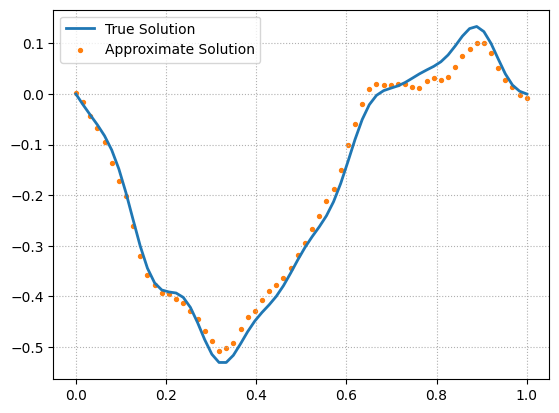

In [624]:
idx_data = 8
input_function_test_n = input_function_test[idx_data, :].unsqueeze(0)
output_function_test_n = output_function_test[idx_data, :].unsqueeze(0)
print(input_function_test_n.shape)
print(output_function_test_n.shape)

output_function_test_pred_n = fno(input_function_test_n)
print(output_function_test_pred_n.shape)
print(input_function_test_n[0,:,1])

plt.figure()
plt.grid(True, which="both", ls=":")
plt.plot(input_function_test_n[0,:,1].detach(), output_function_test_n[0].detach(), label="True Solution", c="C0", lw=2)
plt.scatter(input_function_test_n[0,:,1].detach(), output_function_test_pred_n[0].detach(), label="Approximate Solution", s=8, c="C1")
p = 2
err = (torch.mean(abs(output_function_test_n.detach().reshape(-1, ) - output_function_test_pred_n.detach().reshape(-1, )) ** p) / torch.mean(abs(output_function_test_n.detach()) ** p)) ** (1 / p) * 100
print("Relative L2 error: ", err.item())
plt.legend()

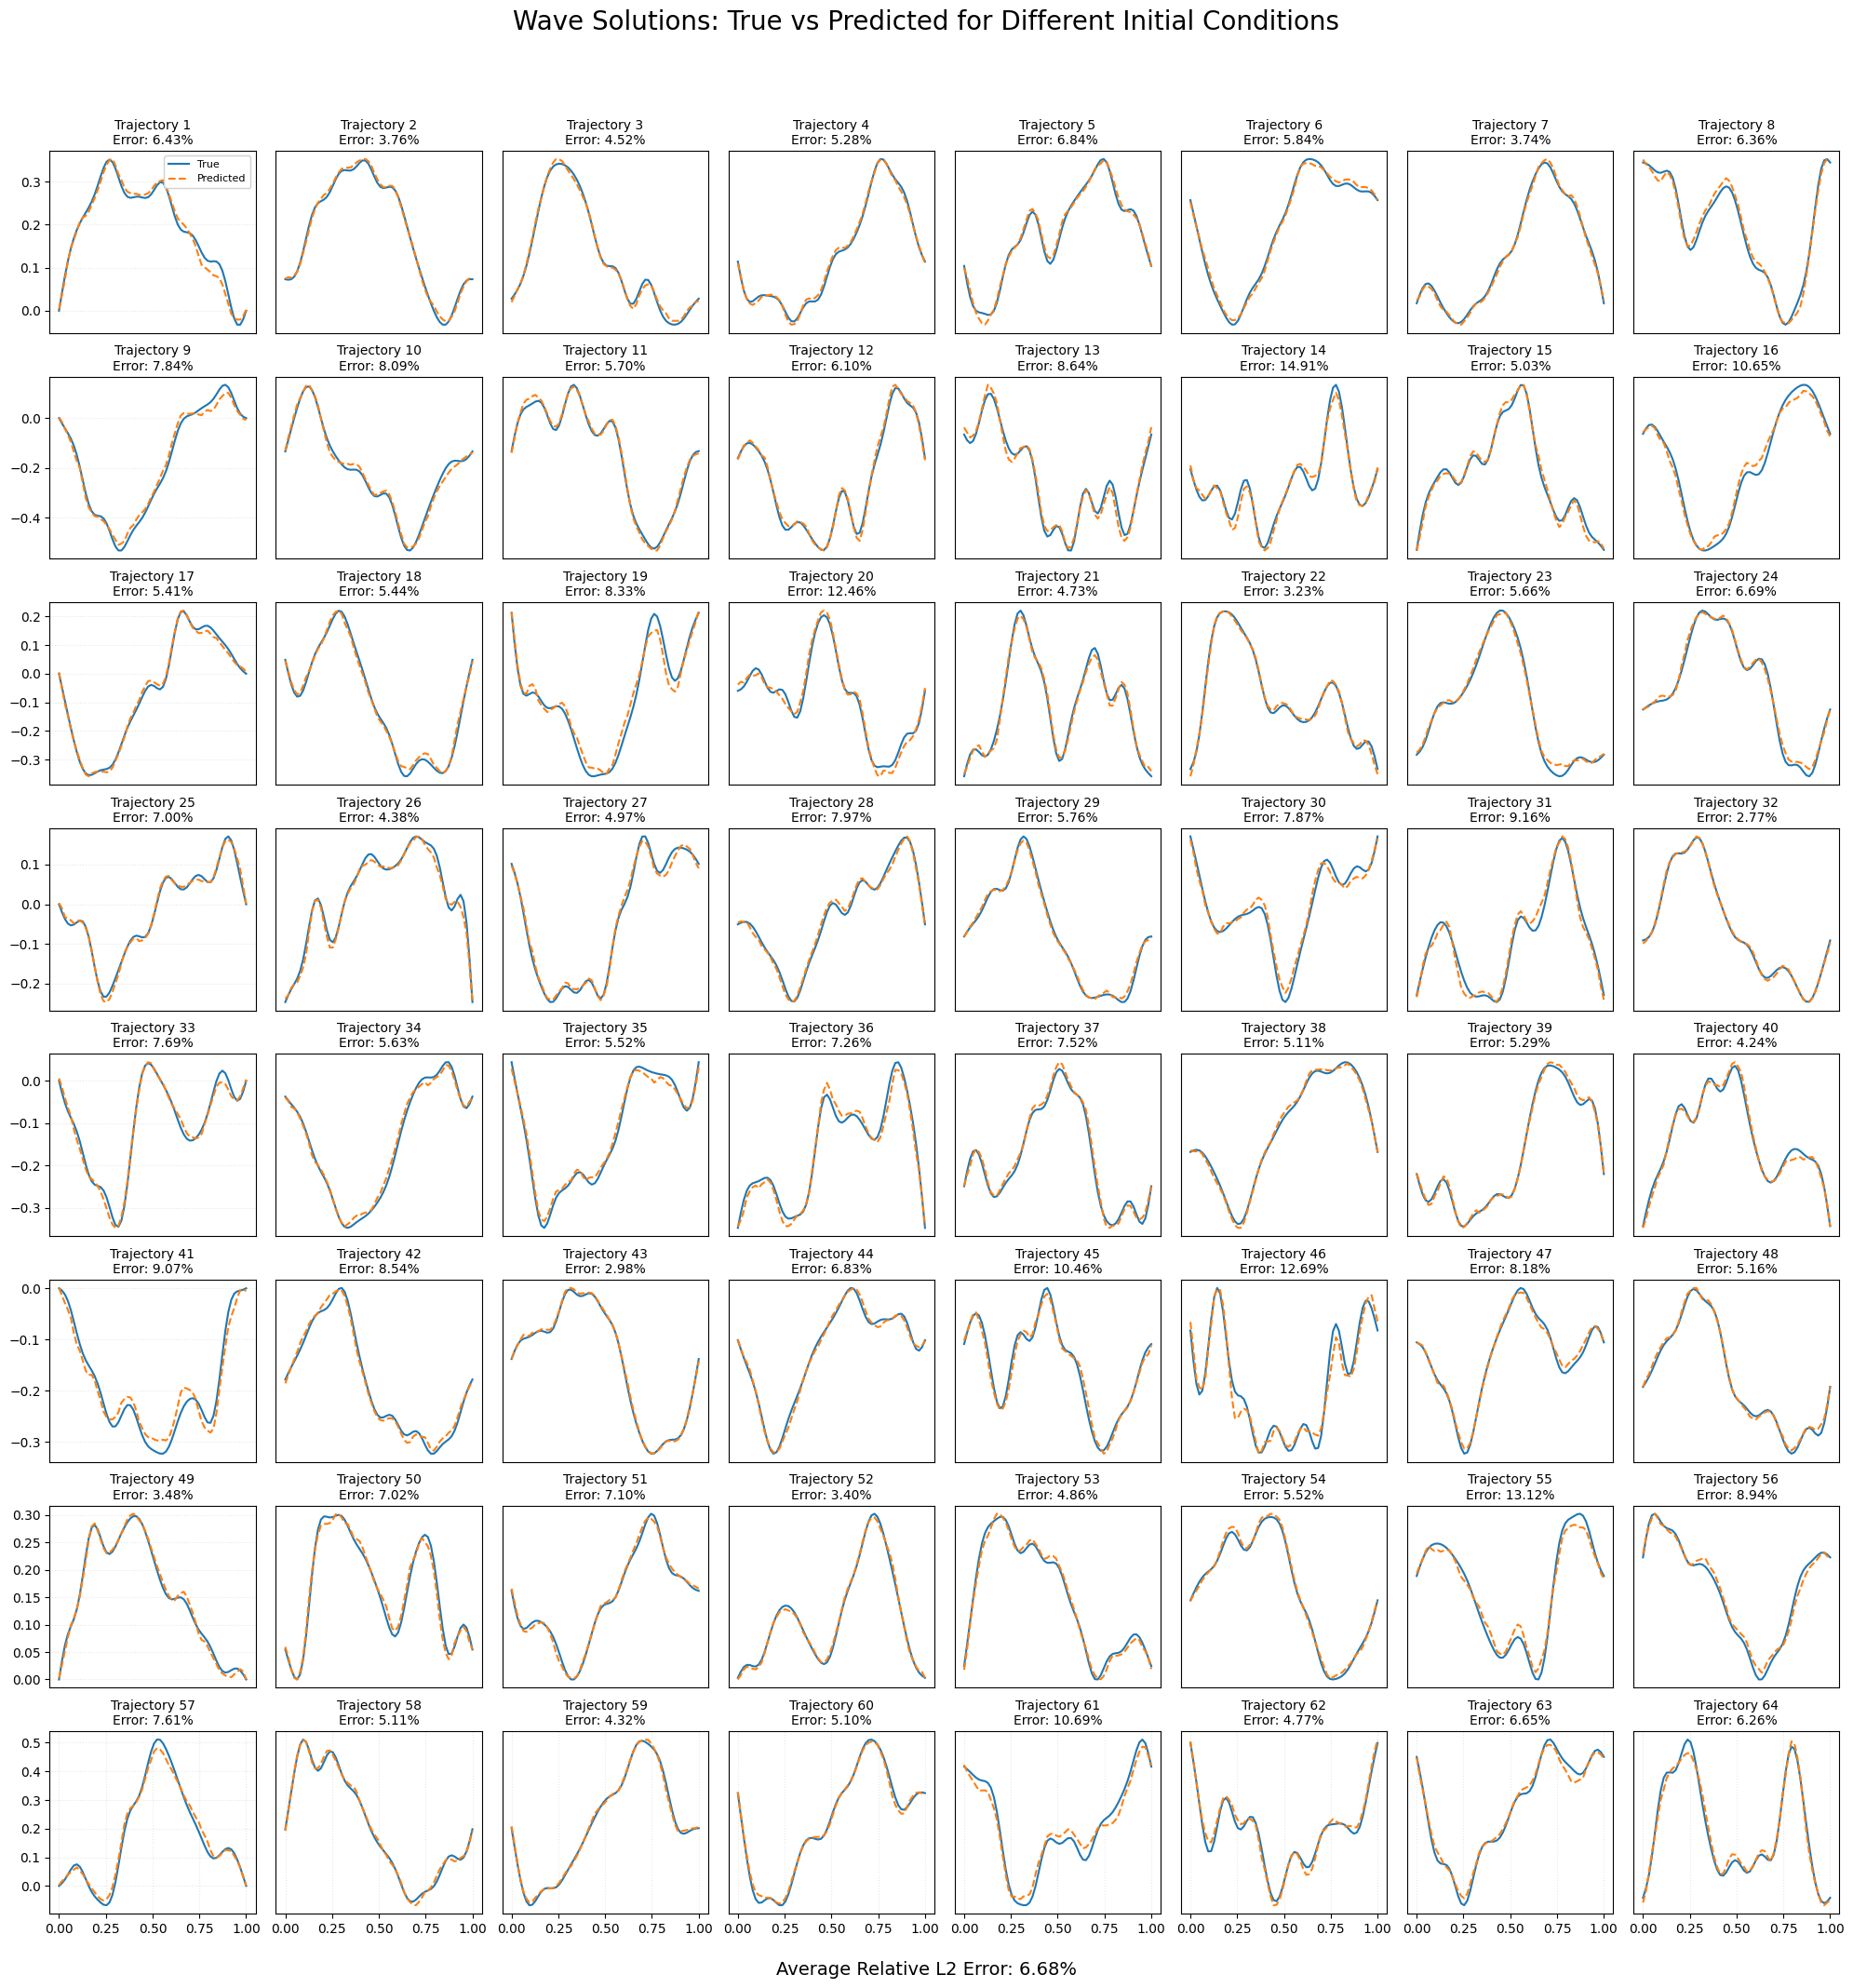

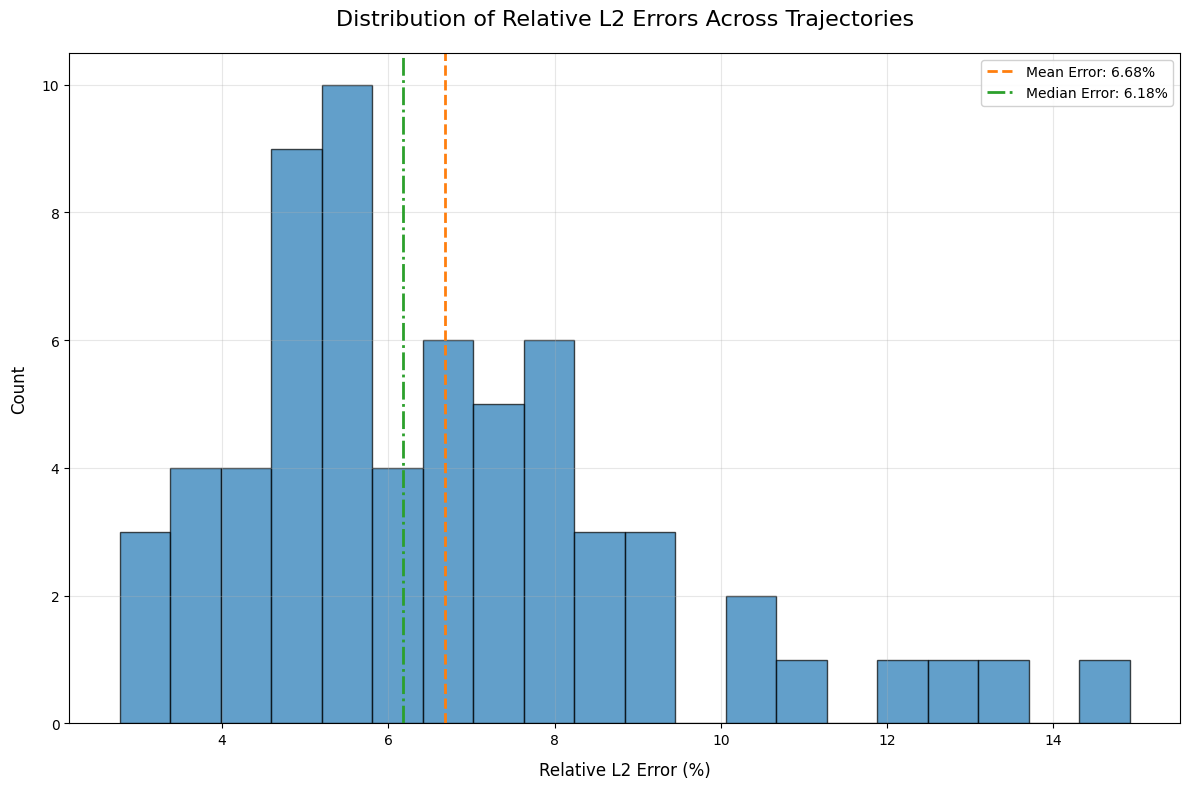

In [625]:
# 1. Grid of Subplots
def plot_trajectory_grid(input_test, output_test, model, num_plots=64, grid_size=(8,8)):
    with torch.no_grad():
        # Create figure with more space at the top for the title
        fig = plt.figure(figsize=(20, 22))  # Increased height for better spacing
        
        # Create GridSpec to have better control over spacing
        gs = fig.add_gridspec(grid_size[0]+1, grid_size[1], height_ratios=[0.2] + [1]*grid_size[0])
        
        # Add title in its own subplot space
        title_ax = fig.add_subplot(gs[0, :])
        title_ax.set_visible(False)
        fig.suptitle('Wave Solutions: True vs Predicted for Different Initial Conditions', 
                    fontsize=20, y=0.98)  # Adjusted position
        
        total_l2_error = 0
        axes = []
        
        for idx in range(num_plots):
            i, j = idx // grid_size[1], idx % grid_size[1]
            
            # Create subplot
            ax = fig.add_subplot(gs[i+1, j])  # +1 because first row is for title
            axes.append(ax)
            
            # Get single trajectory
            input_n = input_test[idx:idx+1, :, :]
            output_true_n = output_test[idx:idx+1, :]
            output_pred_n = model(input_n)
            
            # Calculate relative L2 error using the L2 norm
            numerator = torch.norm(output_pred_n - output_true_n, p=2)
            denominator = torch.norm(output_true_n, p=2)
            err = (numerator / denominator) * 100
            total_l2_error += err.item()
            
            # Plot with improved styling
            ax.grid(True, which="both", ls=":", alpha=0.3)
            ax.plot(input_n[0,:,1].detach(), output_true_n[0].detach(), 
                   label="True", c="#1f77b4", lw=1.5)  # Darker blue
            ax.plot(input_n[0,:,1].detach(), output_pred_n[0].detach(), 
                   label="Predicted", c="#ff7f0e", lw=1.5, ls='--')  # Darker orange
            
            # Improved subplot title
            ax.set_title(f'Trajectory {idx+1}\nError: {err.item():.2f}%', 
                        fontsize=10, pad=5)
            
            # Remove axis labels except for edge plots
            if i != grid_size[0]-1:
                ax.set_xticks([])
            if j != 0:
                ax.set_yticks([])
            
            if idx == 0:  # Legend only on first subplot
                ax.legend(fontsize=8, loc='upper right', framealpha=0.9)
                
        avg_error = total_l2_error / num_plots
        
        # Add average error text with better positioning
        fig.text(0.5, 0.02, f'Average Relative L2 Error: {avg_error:.2f}%', 
                ha='center', fontsize=14, bbox=dict(facecolor='white', 
                                                  alpha=0.8, 
                                                  edgecolor='none', 
                                                  pad=5))
        
        # Adjust spacing between subplots
        plt.tight_layout()
        plt.subplots_adjust(top=0.95, bottom=0.05)
        plt.show()

# 2. Error Distribution
def plot_error_distribution(input_test, output_test, model, num_plots=64):
    with torch.no_grad():
        errors = []
        
        for idx in range(num_plots):
            input_n = input_test[idx:idx+1, :, :]
            output_true_n = output_test[idx:idx+1, :]
            output_pred_n = model(input_n)
            
            numerator = torch.norm(output_pred_n - output_true_n, p=2)
            denominator = torch.norm(output_true_n, p=2)
            err = (numerator / denominator) * 100
            errors.append(err.item())
        
        # Create figure with improved styling
        plt.figure(figsize=(12, 8))
        
        # Plot histogram with better colors and styling
        n, bins, patches = plt.hist(errors, bins=20, edgecolor='black',
                                  color='#1f77b4', alpha=0.7)
        
        # Add mean line with improved styling
        mean_error = np.mean(errors)
        plt.axvline(mean_error, color='#ff7f0e', linestyle='dashed', linewidth=2,
                   label=f'Mean Error: {mean_error:.2f}%')
        
        # Add median line
        median_error = np.median(errors)
        plt.axvline(median_error, color='#2ca02c', linestyle='dashdot', linewidth=2,
                   label=f'Median Error: {median_error:.2f}%')
        
        # Improve plot styling
        plt.title('Distribution of Relative L2 Errors Across Trajectories', 
                 fontsize=16, pad=20)
        plt.xlabel('Relative L2 Error (%)', fontsize=12, labelpad=10)
        plt.ylabel('Count', fontsize=12, labelpad=10)
        plt.legend(fontsize=10, framealpha=0.9)
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# Use all three visualizations
plot_trajectory_grid(input_function_test, output_function_test, fno)
plot_error_distribution(input_function_test, output_function_test, fno)

# Task 2: Testing on Different Resolutions

1. Test the trained model from Task 1 on the datasets test_sol_res_{s}.npy for s ∈ {32, 64, 96, 128}.

2. Compute and report the average relative L2 error for each dataset.

3. What do you observe about the model's performance across different resolutions?



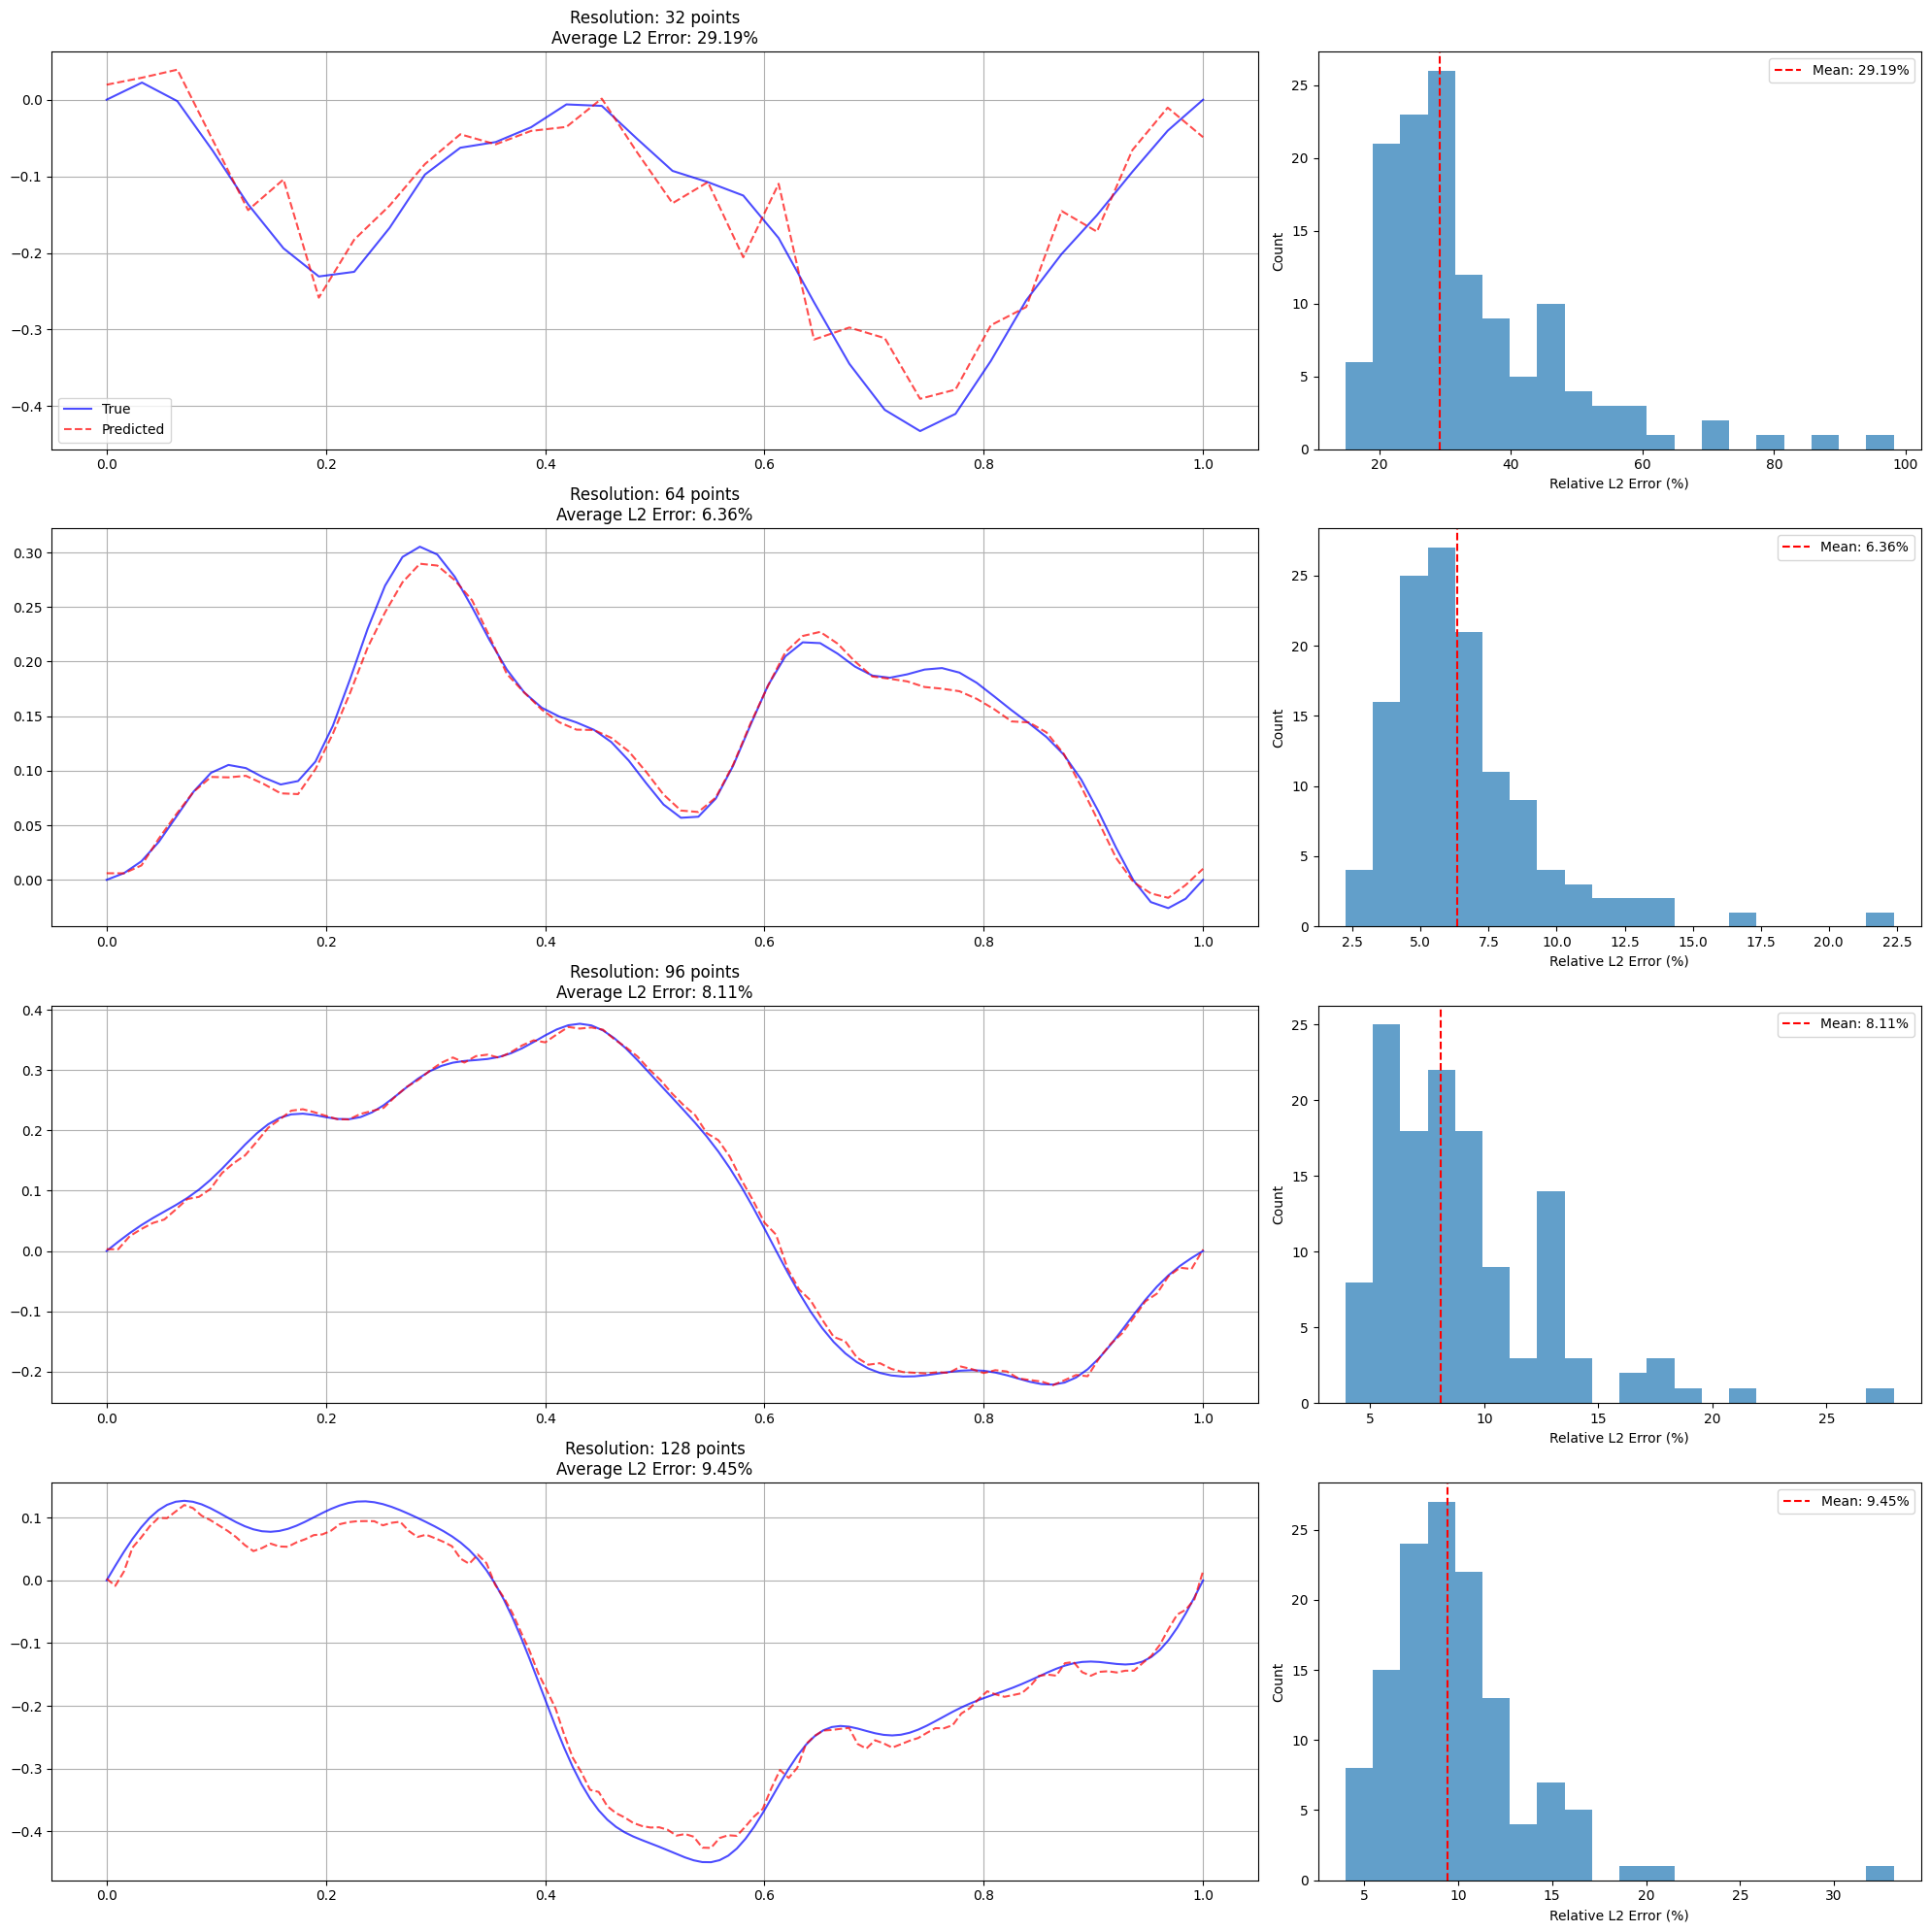


Resolution Test Results:
--------------------------------------------------

Resolution 32:
Average L2 Error: 29.19%
Min Error: 14.85%
Max Error: 98.17%
Std Dev: 14.33%

Resolution 64:
Average L2 Error: 6.36%
Min Error: 2.24%
Max Error: 22.38%
Std Dev: 2.82%

Resolution 96:
Average L2 Error: 8.11%
Min Error: 3.92%
Max Error: 27.94%
Std Dev: 3.76%

Resolution 128:
Average L2 Error: 9.45%
Min Error: 4.00%
Max Error: 33.17%
Std Dev: 3.78%


In [626]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def test_resolution(model, data_path, resolution):
    """Test model on a specific resolution."""
    # Load data
    data = np.load(data_path)
    
    # Extract input (t=0) and output (t=1)
    u_0 = torch.tensor(data[:, 0, :], dtype=torch.float32)
    u_1 = torch.tensor(data[:, 1, :], dtype=torch.float32)
    
    # Create spatial grid for this resolution
    x_grid = torch.linspace(0, 1, resolution).float()
    
    # Prepare input (include spatial coordinates)
    x_grid_expanded = x_grid.expand(u_0.shape[0], -1)
    input_data = torch.stack((u_0, x_grid_expanded), dim=-1)
    
    # Prepare output
    output_data = u_1.unsqueeze(-1)
    
    # Evaluate model
    model.eval()
    with torch.no_grad():
        pred = model(input_data)
        
        # Calculate relative L2 error
        error = torch.norm(pred - output_data, p=2) / torch.norm(output_data, p=2) * 100
        
        # Calculate errors for each sample
        sample_errors = [torch.norm(pred[i] - output_data[i], p=2) / 
                        torch.norm(output_data[i], p=2) * 100 
                        for i in range(len(pred))]
        
    return error.item(), sample_errors, pred, output_data

def plot_resolution_results(model, base_path):
    """Plot results for all resolutions with detailed analysis."""
    resolutions = [32, 64, 96, 128]
    results = {}
    
    # Create figure
    fig = plt.figure(figsize=(20, 5*len(resolutions)))
    gs = plt.GridSpec(len(resolutions), 2, width_ratios=[2, 1])
    
    for i, res in enumerate(resolutions):
        # Test on this resolution
        data_path = f"{base_path}/test_sol_res_{res}.npy"
        avg_error, sample_errors, predictions, targets = test_resolution(model, data_path, res)
        results[res] = {
            'average_error': avg_error,
            'sample_errors': sample_errors
        }
        
        # Plot sample solutions
        ax1 = fig.add_subplot(gs[i, 0])
        x_grid = torch.linspace(0, 1, res)
        ax1.plot(x_grid, targets[0, :, 0].detach(), 'b-', label='True', alpha=0.7)
        ax1.plot(x_grid, predictions[0, :, 0].detach(), 'r--', label='Predicted', alpha=0.7)
        ax1.set_title(f'Resolution: {res} points\nAverage L2 Error: {avg_error:.2f}%')
        ax1.grid(True)
        if i == 0:
            ax1.legend()
        
        # Plot error distribution
        ax2 = fig.add_subplot(gs[i, 1])
        ax2.hist(sample_errors, bins=20, alpha=0.7)
        ax2.axvline(avg_error, color='r', linestyle='--', 
                   label=f'Mean: {avg_error:.2f}%')
        ax2.set_xlabel('Relative L2 Error (%)')
        ax2.set_ylabel('Count')
        ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nResolution Test Results:")
    print("-" * 50)
    for res in resolutions:
        errors = results[res]['sample_errors']
        print(f"\nResolution {res}:")
        print(f"Average L2 Error: {results[res]['average_error']:.2f}%")
        print(f"Min Error: {min(errors):.2f}%")
        print(f"Max Error: {max(errors):.2f}%")
        print(f"Std Dev: {np.std(errors):.2f}%")
    
    return results

# Testing code usage
base_path = "../input/dataset-wave"
results = plot_resolution_results(fno, base_path)

# Task 3: Testing on Out-of-Distribution (OOD) Dataset

1. Test the trained model from Task 1 on the OOD dataset test_sol_OOD.npy.

2. Compute and report the average relative L2 error.

3. Compare the error to the one obtained in Task 1. What do you observe? Is the error higher or lower?



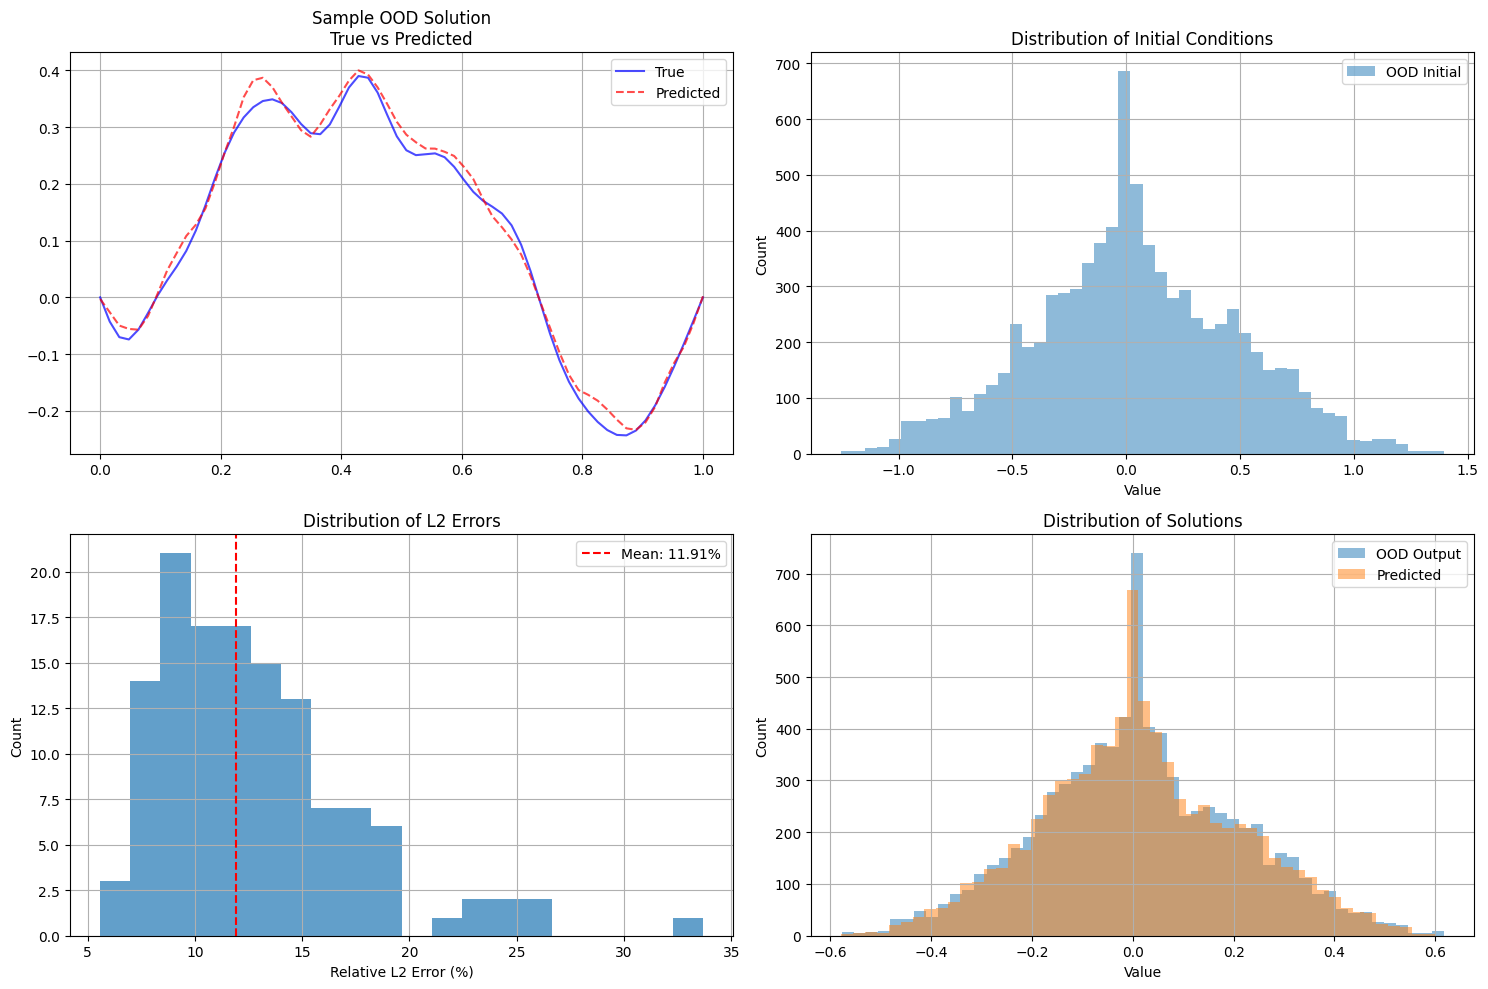


OOD Test Results:
--------------------------------------------------
Average L2 Error: 11.91%
Min Sample Error: 5.58%
Max Sample Error: 33.68%
Error Std Dev: 4.57%


In [627]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def test_ood(model, data_path, original_error=None):
    """
    Test model on OOD dataset and compare with original performance.
    
    Args:
        model: Trained FNO model
        data_path: Path to OOD dataset
        original_error: Error from Task 1 for comparison (optional)
    """
    # Load OOD data
    data = np.load(data_path)
    
    # Extract input (t=0) and output (t=1)
    u_0 = torch.tensor(data[:, 0, :], dtype=torch.float32)
    u_1 = torch.tensor(data[:, 1, :], dtype=torch.float32)
    
    # Create spatial grid
    x_grid = torch.linspace(0, 1, data.shape[2]).float()
    
    # Prepare input (include spatial coordinates)
    x_grid_expanded = x_grid.expand(u_0.shape[0], -1)
    input_data = torch.stack((u_0, x_grid_expanded), dim=-1)
    
    # Prepare output
    output_data = u_1.unsqueeze(-1)
    
    # Evaluate model
    model.eval()
    with torch.no_grad():
        pred = model(input_data)
        
        # Calculate relative L2 error
        error = torch.norm(pred - output_data, p=2) / torch.norm(output_data, p=2) * 100
        
        # Calculate errors for each sample
        sample_errors = [torch.norm(pred[i] - output_data[i], p=2) / 
                        torch.norm(output_data[i], p=2) * 100 
                        for i in range(len(pred))]
    
    # Create visualization
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Sample Solutions
    plt.subplot(2, 2, 1)
    x_grid = torch.linspace(0, 1, data.shape[2])
    plt.plot(x_grid, output_data[0, :, 0].detach(), 'b-', label='True', alpha=0.7)
    plt.plot(x_grid, pred[0, :, 0].detach(), 'r--', label='Predicted', alpha=0.7)
    plt.title('Sample OOD Solution\nTrue vs Predicted')
    plt.grid(True)
    plt.legend()
    
    # Plot 2: Initial Conditions Comparison
    plt.subplot(2, 2, 2)
    plt.hist(u_0.numpy().flatten(), bins=50, alpha=0.5, label='OOD Initial')
    plt.title('Distribution of Initial Conditions')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    
    # Plot 3: Error Distribution
    plt.subplot(2, 2, 3)
    plt.hist(sample_errors, bins=20, alpha=0.7)
    plt.axvline(error.item(), color='r', linestyle='--', 
                label=f'Mean: {error.item():.2f}%')
    if original_error is not None:
        plt.axvline(original_error, color='g', linestyle='--', 
                   label=f'Original: {original_error:.2f}%')
    plt.title('Distribution of L2 Errors')
    plt.xlabel('Relative L2 Error (%)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    
    # Plot 4: Solution Distribution
    plt.subplot(2, 2, 4)
    plt.hist(output_data.numpy().flatten(), bins=50, alpha=0.5, label='OOD Output')
    plt.hist(pred.numpy().flatten(), bins=50, alpha=0.5, label='Predicted')
    plt.title('Distribution of Solutions')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nOOD Test Results:")
    print("-" * 50)
    print(f"Average L2 Error: {error.item():.2f}%")
    print(f"Min Sample Error: {min(sample_errors):.2f}%")
    print(f"Max Sample Error: {max(sample_errors):.2f}%")
    print(f"Error Std Dev: {np.std(sample_errors):.2f}%")
    
    if original_error is not None:
        print(f"\nComparison with Original Performance:")
        print(f"Original Error: {original_error:.2f}%")
        print(f"Difference: {error.item() - original_error:.2f}%")
        print(f"Relative Change: {((error.item() - original_error) / original_error * 100):.2f}%")
    
    return error.item(), sample_errors, pred, output_data

# Usage example
base_path = "../input/dataset-wave"
original_error = None  # Replace with your Task 1 error if available

# Test on OOD dataset
ood_error, ood_samples, predictions, targets = test_ood(
    model=fno,
    data_path=f"{base_path}/test_sol_OOD.npy",
    original_error=original_error
)

Task 1 Test Error: 6.44%


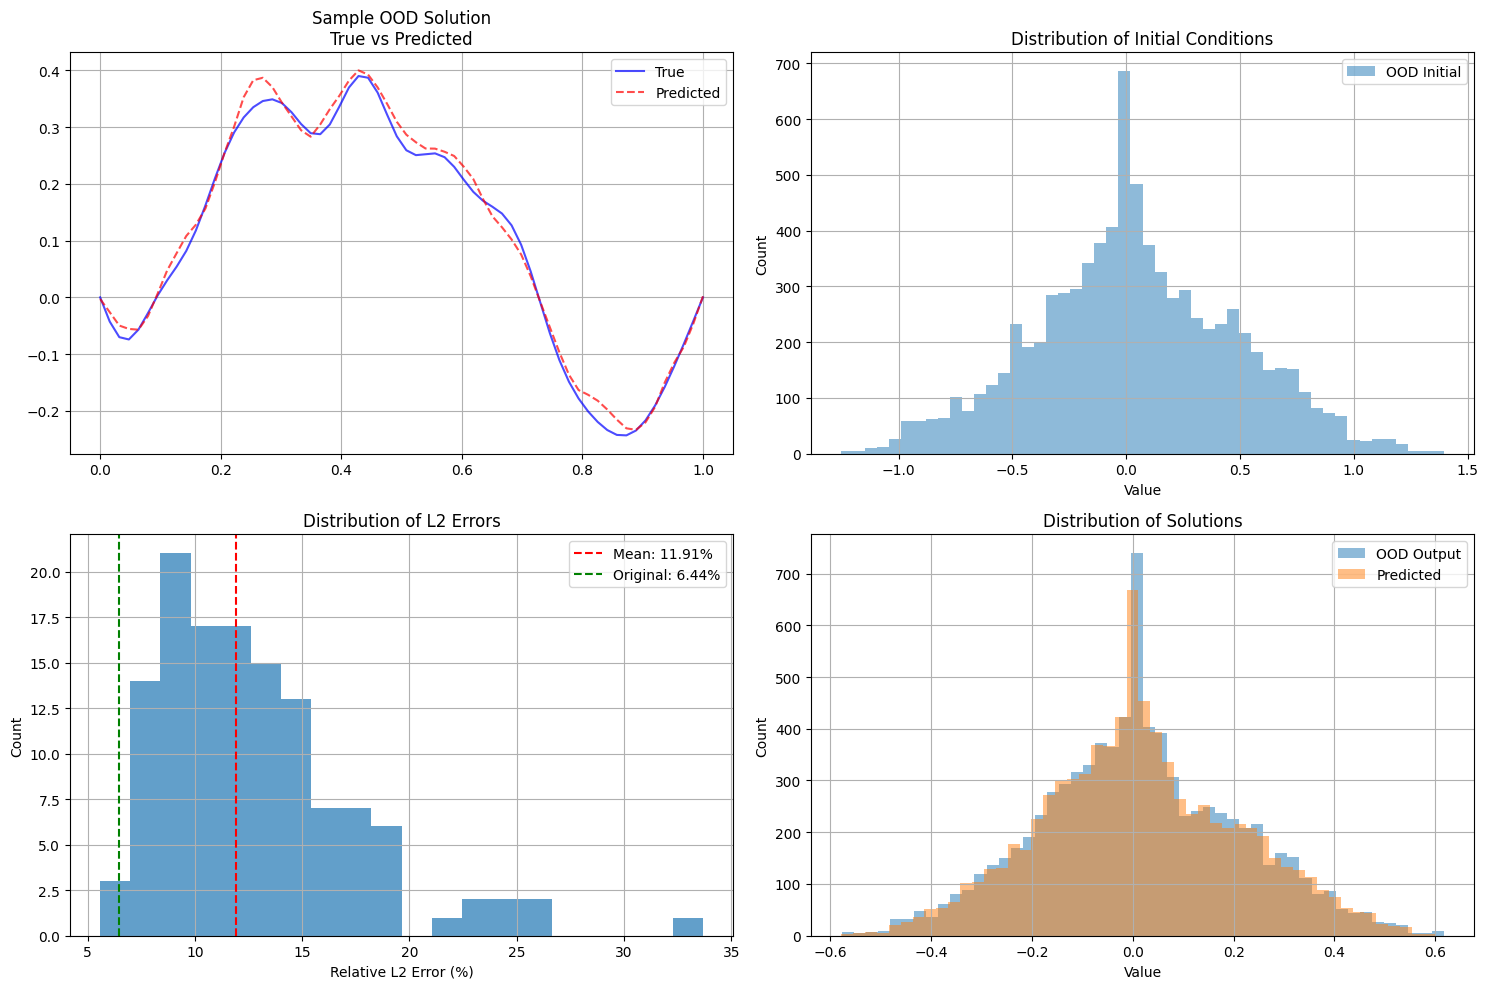


OOD Test Results:
--------------------------------------------------
Average L2 Error: 11.91%
Min Sample Error: 5.58%
Max Sample Error: 33.68%
Error Std Dev: 4.57%

Comparison with Original Performance:
Original Error: 6.44%
Difference: 5.47%
Relative Change: 84.91%

Comparison:
Task 1 Error: 6.44%
OOD Error: 11.91%
Difference: 5.47%
Relative Change: 84.91%


In [628]:
def calculate_test_error(model, test_loader):
    model.eval()
    total_error = 0.0
    num_samples = 0
    
    with torch.no_grad():
        for input_batch, output_batch in test_loader:
            pred = model(input_batch)
            # Calculate relative L2 error
            error = torch.norm(pred - output_batch, p=2) / torch.norm(output_batch, p=2) * 100
            total_error += error.item() * len(input_batch)
            num_samples += len(input_batch)
    
    return total_error / num_samples

# Calculate Task 1 error
task1_error = calculate_test_error(fno, testing_set)
print(f"Task 1 Test Error: {task1_error:.2f}%")

# Calculate OOD error using our previous function
ood_error, _, _, _ = test_ood(fno, "../input/dataset-wave/test_sol_OOD.npy", task1_error)

# Compare the errors
print("\nComparison:")
print(f"Task 1 Error: {task1_error:.2f}%")
print(f"OOD Error: {ood_error:.2f}%")
print(f"Difference: {ood_error - task1_error:.2f}%")
print(f"Relative Change: {((ood_error - task1_error) / task1_error * 100):.2f}%")

# Task 4: All2All Training

1. Use 64 trajectories from the training dataset.

2. Use all provided time snapshots (t = 0.0, 0.25, 0.50, 0.75, 1.0) for these trajectories to train a time-dependent FNO model. Note that this is similar to the task that we had in time-dependent CNO tutorial. *Hint: Use time-conditional batch normalization and include time as one of the input channels.*

3. What is the total number of samples used for training in the All2All approach?

4. Test the trained model on the test_sol.npy dataset, focusing only on predictions at t = 1.0.

5. Report the average relative L2 error.

6. Compare the error to the one obtained in Task 1. What do you observe?



# Bonus Task

1. Use the model from Task 4 to make predictions at multiple time steps: t = 0.25, t = 0.50, t = 0.75, t = 1.0.

2. Compute the average relative L2 error for each time step.

3. What do you observe about the model's performance over time?

4. Use the model from Task 4 to make predictions on the OOD dataset at t = 1.0.

5. What do you observe about the model's performance?